# Check q-voter phase transition

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

plt.style.use("../config/custom_plots.mplstyle")

```yaml
nAgents: 10000
nSteps: 100
nSaveSteps: 1
nRuns: 10
networkP: 0.8
networkM: 10
additionalLinksFraction: 0.01
virtualLayer: true
epidemicLayer: true
comorbidities: false
qVoterParameters:
  p: 0.2
  q: 6
epidemicLayerParameters:
  beta: 0.1
  zeta: 0.0
  alpha: 0.0
  gamma: 0.5
  mu: 0.9
  kappa: 0.1
maxInfectedTimeMean: 10
maxInfectedTimeStd: 5
positiveOpinionFraction: 1.0
proPisFraction: 0.0
pisVaccinationCorrelation: 0.0
infectedFraction: 0.1
fractionIllnessA: 0.0
fractionIllnessB: 0.0
outputFolder: simulations/appendix_qvoter_transition
firstParameterRange:
  start: 0.0
  end: 0.5
  count: 101
  vals: null
  type: p
secondParameterRange: null
  # start: 0.0
  # end: 1.0
  # count: 0
  # vals: [2, 3, 4, 5, 6, 7, 8, 9, 10]
  # type: q
thirdParameterRange: null
linksRemoval: false
nQVoterPerStep: 1
vaccinationFraction: 0.0
neglectNeighboursPiS: false
```

In [2]:
def load_df(prefix, folder, p, q, fracPos=1.0, beta='0,10', nagents=10000, qvotersteps=1, nsteps=100, nruns=5):
    dfs = []
    for n in range(nruns):
        path = f"../simulations/{folder}/{prefix}_NAGENTS={nagents}_NSTEPS={nsteps}_NETWORKP=0.8_FRAC_LINKS=0.01_FRAC_POS_OPINION={fracPos}_FRAC_INFECTED=0.1_QVOTER=p={p}_q={q}_PIS=0.0_EPIDEMIC=beta={beta}_zeta=0,00_alpha=0,00_gamma=0,50_mu=0,90_kappa=0,10_QVOTERSTEPS={qvotersteps}_NRUN={n}.tsv"
        
        df = pd.read_csv(path, sep="\t")
        dfs.append(df)
    dfs1 = pd.DataFrame(np.array([x.to_numpy() for x in dfs]).mean(axis=0),
                        index=df.index, 
                        columns=df.columns)
    return dfs1

ps = ['{:.2f}'.format(x / 101) for x in range(51)]
ps = [p.replace('.', ',') for p in ps]

qs = list(range(2, 11))

print('ps: ', ps, len(ps))
print('qs: ', qs, len(qs))

ps:  ['0,00', '0,01', '0,02', '0,03', '0,04', '0,05', '0,06', '0,07', '0,08', '0,09', '0,10', '0,11', '0,12', '0,13', '0,14', '0,15', '0,16', '0,17', '0,18', '0,19', '0,20', '0,21', '0,22', '0,23', '0,24', '0,25', '0,26', '0,27', '0,28', '0,29', '0,30', '0,31', '0,32', '0,33', '0,34', '0,35', '0,36', '0,37', '0,38', '0,39', '0,40', '0,41', '0,42', '0,43', '0,44', '0,45', '0,46', '0,47', '0,48', '0,49', '0,50'] 51
qs:  [2, 3, 4, 5, 6, 7, 8, 9, 10] 9


In [3]:
def load_dfs(N, ps=ps, qs=qs, path='appendix_qvoter_transition', prefix='off'):
    """
    { q: list of dataframes, one per `p` value }
    """
    xs = {}
    for q in tqdm(qs):
        xs_per_q = []
        for p in ps:
            df1 = load_df(prefix, path, p, q, nagents=N)
            xs_per_q.append(df1)
        xs[q] = xs_per_q
    return xs

In [4]:
%%time


dfs_3000 = load_dfs(3000)
dfs_10000 = load_dfs(10000)
dfs_30000 = load_dfs(30000)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 43.4 s, sys: 749 ms, total: 44.1 s
Wall time: 44.7 s


In [38]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


colors = 2 * ['red', 'green', 'blue', 'purple', 'brown']
colors = ['xkcd:' + c for c in colors]
markers = 2 * ['o', 'v', '^', 'D', 's', 'X', '>', '<']

def max_infection_rate(df):
    return df['infectedRate'].max()

def max_quarantine_rate(df):
    return df['quarantinedRate'].max()

def last_opinion(df):
    return df['meanOpinion'].to_numpy()[-1]

def last_recovered_rate(df):
    return df['recoveredRate'].to_numpy()[-1]

def time_max_infection(df):
    return df[df['infectedRate'] == df['infectedRate'].max()].step.to_numpy()[0]


def plot_last_opinion_vs_p(dfs, ps=ps, markers=markers, colors=colors, 
                           fun=last_opinion, add_legend=False):
    i = 0
    markers_legend = []
    ps_float = [float(p.replace(',', '.')) for p in ps]
    for q, df in dfs.items():
        y = [fun(x) for x in df]
#         plt.plot(ps_float, y, 'o--', label=f'q={q}', linewidth=1, color=colors[i], 
#                  marker=markers[i], mfc='none', markersize=7, alpha=0.5)
        plt.plot(ps_float, y, linestyle='', label=f'q={q}', linewidth=1, color=colors[i], 
                 marker=markers[i], mfc='none', markersize=7, alpha=0.5)
        
        i += 1
    
    plt.xlabel(r'$p$')
    plt.ylabel(r'$c$') # max infection rate
    if add_legend:
        plt.legend()

In [42]:
def analytical_phase_transition_point(q, k):
    """
    Solution from [1] Eq. 34
    
    [1] Jędrzejewski, A. (2017). 
        Pair approximation for the $q$-voter model with independence on complex networks. 
        Phys. Rev. E, 95, 012307.
    """
    top = q - 1
    bottom = q - 1 + np.power(2, q - 1) * np.power((k - 1) / (k - 2), q)
    return top / bottom


def plot_analytical_phase_transition_points(qs=qs, k=20):
    i = 0
    for q in qs:
        plt.scatter([analytical_phase_transition_point(q, k)], [0.0], color=colors[i], s=120, 
                    edgecolors='black', linewidths=2, marker=markers[i], zorder=10)
        i += 1

Text(0.5, 1.0, 'N=3000')

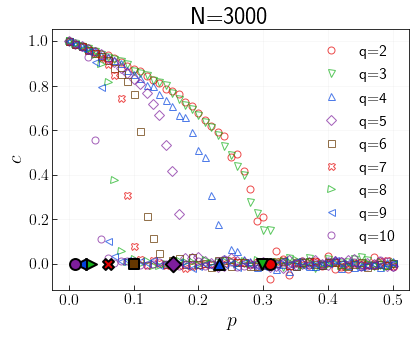

In [43]:
plot_last_opinion_vs_p(dfs_3000, add_legend=True)
plot_analytical_phase_transition_points()
plt.title('N=3000')

Text(0.5, 1.0, 'N=10000')

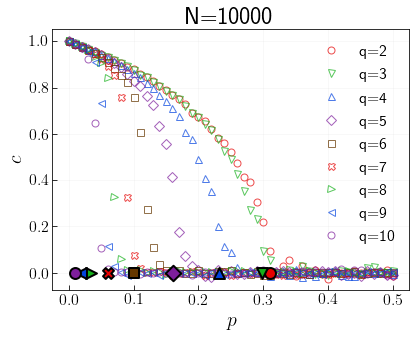

In [44]:
plot_last_opinion_vs_p(dfs_10000, add_legend=True)
plot_analytical_phase_transition_points()
plt.title('N=10000')

Text(0.5, 1.0, 'N=30000')

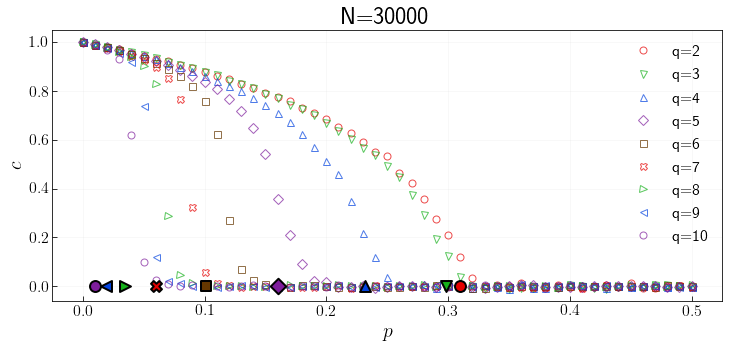

In [46]:
plt.figure(figsize=(12, 5))
plot_last_opinion_vs_p(dfs_30000, add_legend=True)
plot_analytical_phase_transition_points()

plt.title('N=30000')